In [29]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


In [ ]:
backend = AerSimulator()

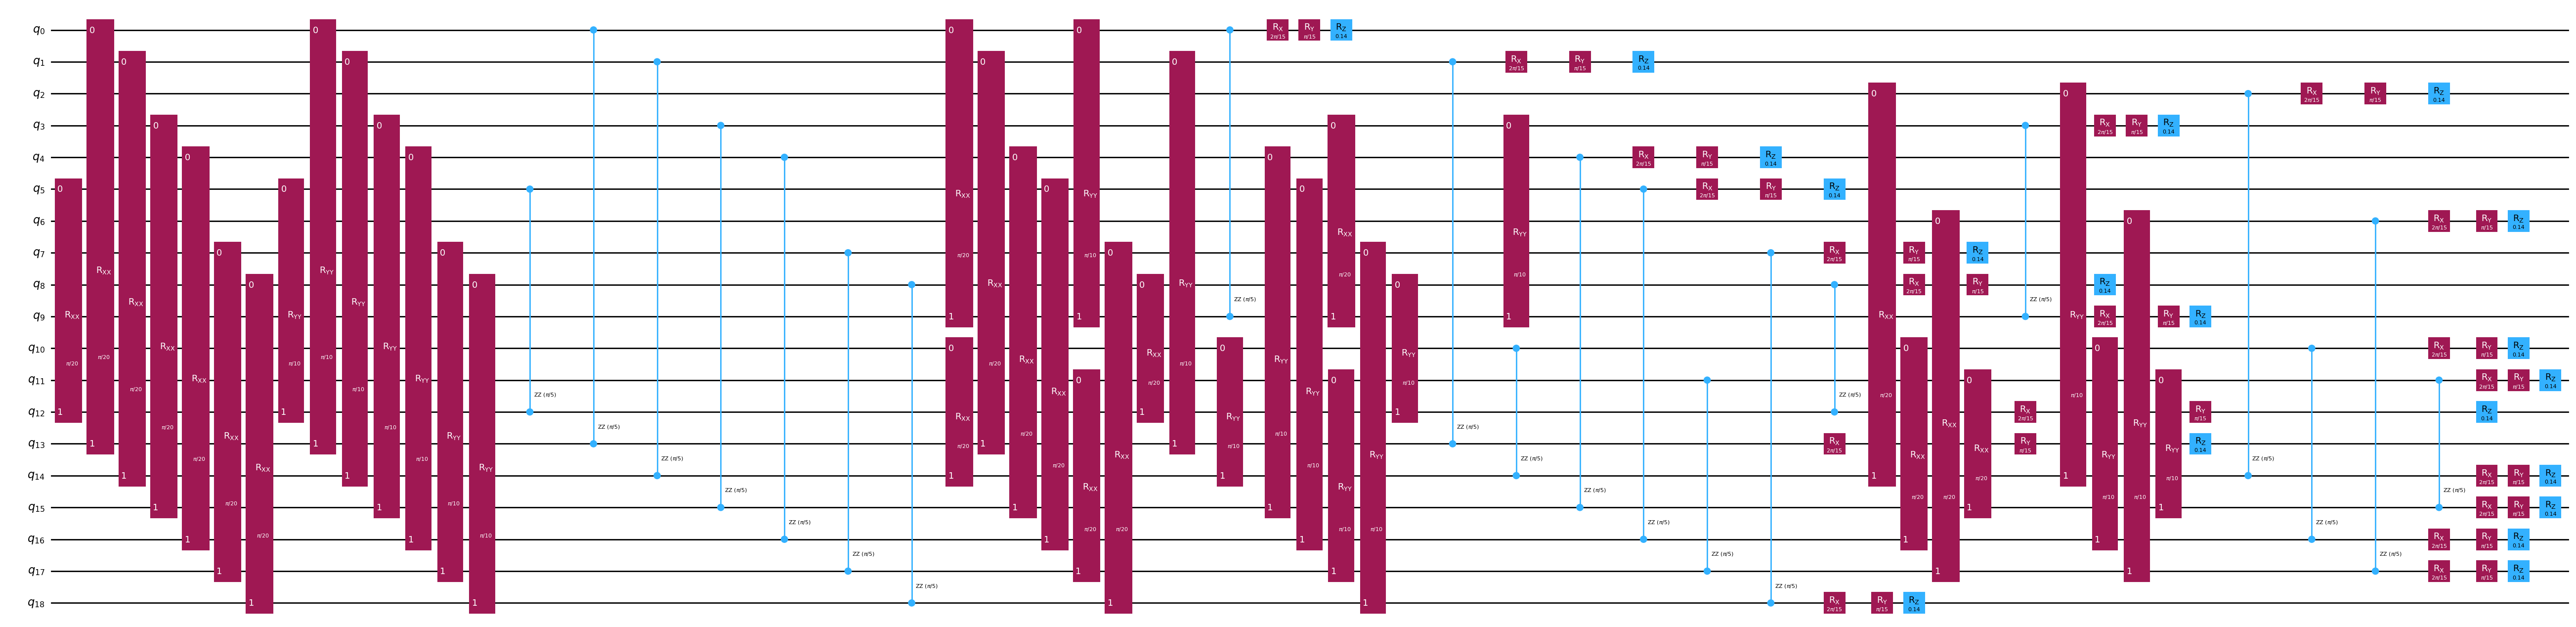

In [31]:
coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=True)

#reduced_coupling_map = coupling_map.reduce(
#    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18, 7, 17, 11, 15, 3]
#)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=1), time=0.2
)


circuit.draw("mpl", fold =-1)

In [4]:
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIII', 'IIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIZ'],
              coeffs=[0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j])


In [8]:
obs_matrix = observable.to_matrix(sparse=True)

In [9]:
from scipy.sparse.linalg import eigsh
eigenval, _ = eigsh(obs_matrix)
eigenval

array([ 1.        , -1.        ,  0.89473684,  0.89473684,  0.89473684,
       -0.89473684])

In [10]:
float(min(eigenval))

-1.000000000000005

In [11]:
from qiskit_ibm_runtime.fake_provider import FakeTorino
backend = FakeTorino()

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(circuit)

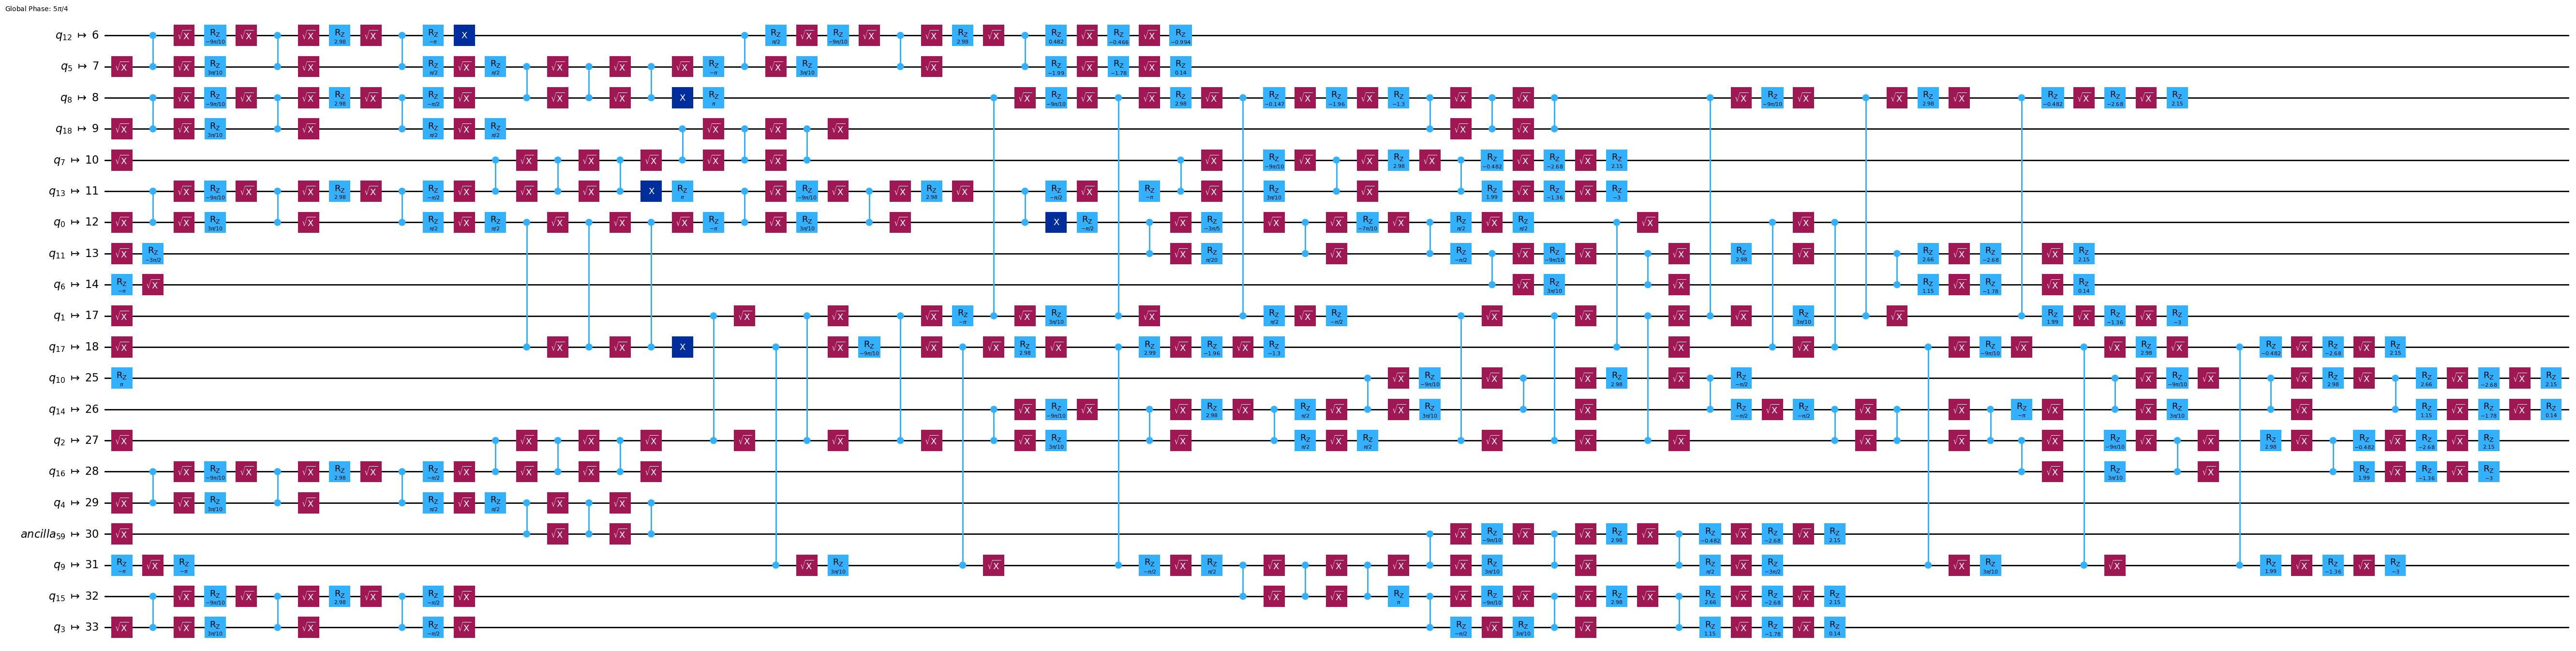

In [13]:
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp", fold=-1)

In [ ]:
observable_isa = observable.apply_layout(layout=circuit_isa.layout)

In [19]:
estimator = Estimator(mode=backend)

In [20]:
job = estimator.run([(ansatz_isa, hamiltonian_isa)])
result = job.result()[0]
energy = result.data.evs
energy

array(-0.87548828)

## Try with Cutting only

In [21]:
synth_ansatz = ansatz.assign_parameters(res.x)

In [ ]:
pm_basis = generate_preset_pass_manager(optimization_level=3, basis_gates=backend.configuration().basis_gates, seed_transpiler=1)
synth_ansatz = pm_basis.run(synth_ansatz)

Found solution using 3 cuts with a sampling overhead of 729.0.
Lowest cost solution found: True.
Gate Cut at circuit instruction index 66
Gate Cut at circuit instruction index 97
Gate Cut at circuit instruction index 120


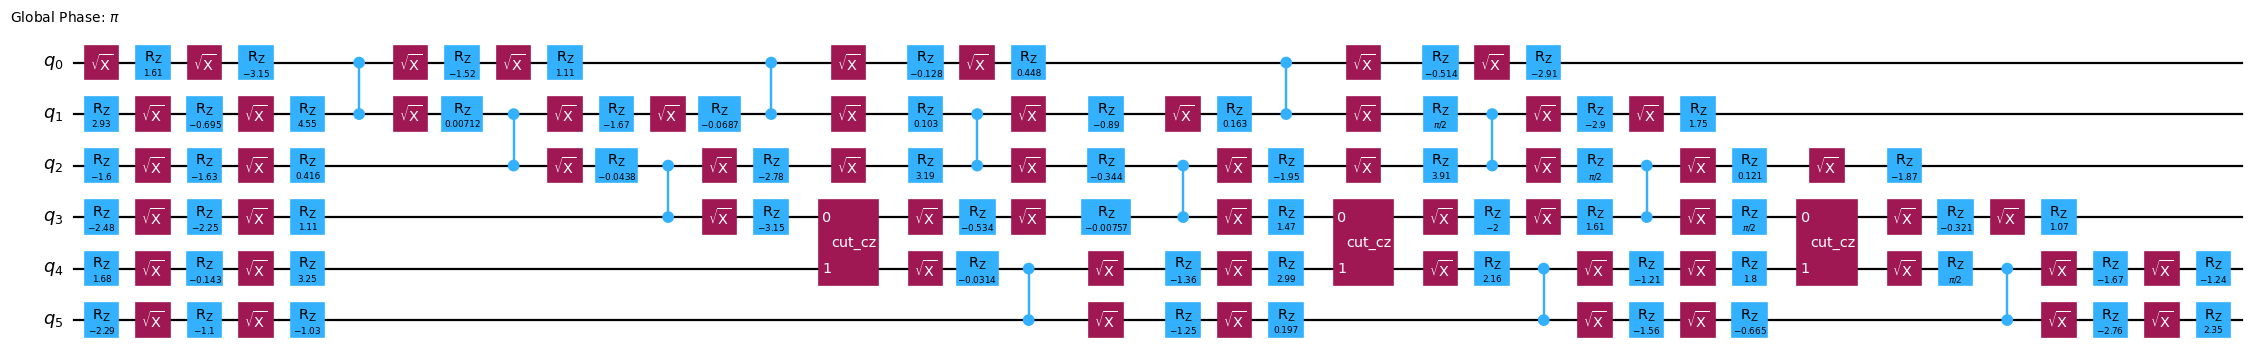

In [23]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)


# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(synth_ansatz.num_qubits/2)+1)

cut_circuit, metadata = find_cuts(synth_ansatz, optimization_settings, device_constraints)
#print(metadata)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

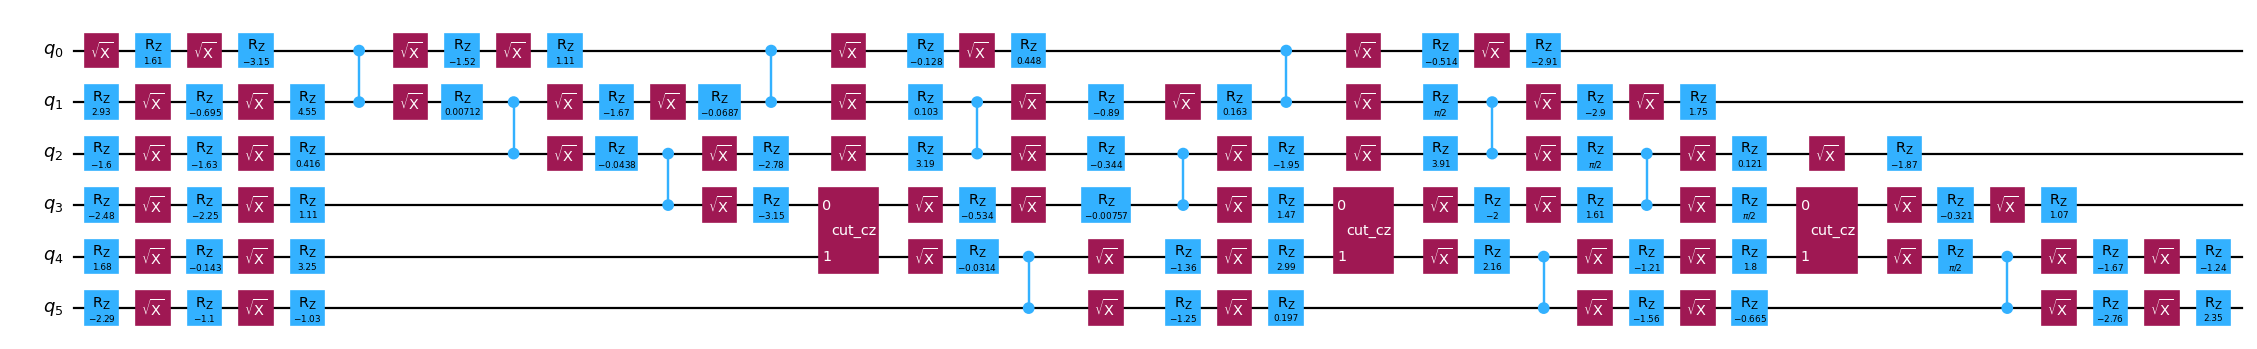

In [24]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, synth_ansatz, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [25]:
print(observables_expanded)

['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ']


In [26]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

#subcircuits[1].draw("mpl")

Sampling overhead: 729.0


In [27]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
print(f"Total subexperiments are ",total_subexperiments)

Total subexperiments are  432


In [28]:
backend = FakeTorino()
    # Transpile the subexperiments to ISA circuits
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
isa_subexperiments = {
        label: pass_manager.run(partition_subexpts)
        for label, partition_subexpts in subexperiments.items()
        }

#print(isa_subexperiments)

In [29]:
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(mode=backend)
job0 = {
        label: sampler.run(subsystem_subexpts, shots=10000)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

In [30]:
results0 = {label: job.result() for label, job in job0.items()}
#print(results0)

In [32]:
from qiskit_addon_cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results0,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
print(reconstructed_expval.real)


-0.9059642066665


## OBP then Cut

In [36]:
from qiskit_addon_utils.slicing import slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
# Define an operator budget list
max_qwc_groups= 40
op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)
# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_ansatz, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 38 slices.


In [37]:
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices
# Backpropagate without the truncation error budget


backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
    )
    # Recombine the slices remaining after backpropagation
bp_circuit = combine_slices(remaining_slices, include_barriers=False)
num_non_commuting_groups=backpropagated_observable.group_commuting()
if bp_circuit != None:
        print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())




Depth of the backpropagated circuit is:  21


In [38]:
# Form the list of cut circuits
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)
    # Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
    #print(metadata)
print(
        f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
        f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
        #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
    )


Found solution using 1 cuts with a sampling overhead of 9.0.



In [39]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(bp_cut_circuit)
observables_expanded = expand_observables(backpropagated_observable.paulis, bp_circuit, qc_w_ancilla)
 

In [40]:

partitioned_problem = partition_problem(
        circuit=qc_w_ancilla, observables=observables_expanded
    )
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
        f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
    )

   

Sampling overhead: 9.0


In [41]:
from qiskit_addon_cutting import generate_cutting_experiments
subexperiments, coefficients = generate_cutting_experiments(
        circuits=subcircuits, observables=subobservables, num_samples=np.inf
    )
total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
    

print(total_subexperiments)

120


In [42]:
backend = FakeTorino()
# Transpile the subexperiments to ISA circuits
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
isa_subexperiments = {
        label: pass_manager.run(partition_subexpts)
        for label, partition_subexpts in subexperiments.items()
        }


In [68]:
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(mode=backend)
job0 = {
        label: sampler.run(subsystem_subexpts, shots=10000)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

In [71]:
results0 = {label: job.result() for label, job in job0.items()}
#print(results0)

In [72]:
from qiskit_addon_cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results0,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, backpropagated_observable.coeffs)
print(reconstructed_expval.real)

-0.868988308808591


In [ ]:
array(-0.84375)
(-0.8781359641665109+0j)
-0.868988308808591

## Scratch Pad

In [36]:
# Define an operator budget list
operator_budget_list =[]
max_qwc_groups_list=range(1,40)
for max_qwc_groups in max_qwc_groups_list:
    op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)
    operator_budget_list.append(op_budget)
print(operator_budget_list)
# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_ansatz, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

[OperatorBudget(max_paulis=None, max_qwc_groups=1, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=2, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=3, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=4, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=5, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=6, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=7, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=8, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=9, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=10, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=11, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=Non

In [37]:
# Backpropagate without the truncation error budget
bp_circuit_list =[]
commuting_groups_list=[] # Stores the list of the non-commutig groups after backpropagation
backpropagated_observable_list =[]

for op_budget in operator_budget_list:
    backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
    )
    # Recombine the slices remaining after backpropagation
    bp_circuit = combine_slices(remaining_slices, include_barriers=False)
    num_non_commuting_groups=backpropagated_observable.group_commuting()
    if bp_circuit != None:
        print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())
    #else:
    #    bp_circuit =QuantumCircuit(circuit.num_qubits)
        bp_circuit_list.append(bp_circuit)
    commuting_groups_list.append(len(num_non_commuting_groups))
    backpropagated_observable_list.append(backpropagated_observable)



Depth of the backpropagated circuit is:  38
Depth of the backpropagated circuit is:  36
Depth of the backpropagated circuit is:  35
Depth of the backpropagated circuit is:  33
Depth of the backpropagated circuit is:  33
Depth of the backpropagated circuit is:  33
Depth of the backpropagated circuit is:  30
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circ

In [38]:
# Form the list of cut circuits
bp_cut_circuit_list =[]
bp_num_cuts_list =[]
bp_cut_sampling_overhead_list =[]
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

for bp_circuit in bp_circuit_list:
    # Specify the size of the QPUs available
    device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

    bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
    #print(metadata)
    print(
        f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
        f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
        #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
    )
    bp_cut_circuit_list.append(bp_cut_circuit)
    bp_num_cuts_list.append(len(bp_cut_metadata["cuts"]))
    bp_cut_sampling_overhead_list.append(bp_cut_metadata["sampling_overhead"])


print(bp_cut_circuit_list)
print(bp_num_cuts_list)
print(bp_cut_sampling_overhead_list)

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 1296.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampli

In [39]:
from qiskit_addon_cutting import cut_wires, expand_observables
qc_w_ancilla_list=[]
observables_expanded_list=[]
for cut_ckt, bp_obs, bp_ckt in zip(bp_cut_circuit_list, backpropagated_observable_list, bp_circuit_list):
    qc_w_ancilla = cut_wires(cut_ckt)
    observables_expanded = expand_observables(bp_obs.paulis, bp_ckt, qc_w_ancilla)
    qc_w_ancilla_list.append(qc_w_ancilla)
    observables_expanded_list.append(observables_expanded)
    
    
    #qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)
print(qc_w_ancilla_list)
print(observables_expanded_list)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1375ebdd0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x145bf8860>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x14383c560>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1424c70b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1424c6930>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x143f3c320>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x146c9e6c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13432d6a0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x134f99d00>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x133aabb90>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x142194fe0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x145d8f770>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x144263f50>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3123821b0>, <qiskit.circuit.qua

In [40]:
from qiskit_addon_cutting import partition_problem

subcircuits_list =[]
subobservables_list =[]
for qc_w_anc, obs_expan in zip(qc_w_ancilla_list, observables_expanded_list):

    partitioned_problem = partition_problem(
        circuit=qc_w_anc, observables=obs_expan
    )
    subcircuits = partitioned_problem.subcircuits
    subobservables = partitioned_problem.subobservables
    print(
        f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
    )
    subcircuits_list.append(subcircuits)
    subobservables_list.append(subobservables)
    #subcircuits[1].draw("mpl")
print(subcircuits_list)
print(subobservables_list)

Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 1296.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
[{0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x143cd02c0

In [41]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments_list =[]

for subckt, subobs in zip(subcircuits_list, subobservables_list):
    subexperiments, coefficients = generate_cutting_experiments(
        circuits=subckt, observables=subobs, num_samples=np.inf
    )
    #print(subexperiments)
    #break
    # print(
    #     f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
    # )
    # for i in list(subexperiments.keys()):
    #     subexperiments = len(subexperiments[i])
    # subexperiments_list.append(subexperiments)
    # Assisted by watsonx Code Assistant
    
    total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
    subexperiments_list.append(total_subexperiments)
    

print(subexperiments_list)

[1536, 3072, 4096, 6144, 6144, 6144, 4032, 192, 192, 192, 216, 216, 216, 216, 216, 216, 216, 156, 156, 156, 156, 156, 156, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]


In [44]:


import matplotlib.pyplot as plt



y_data = [1536, 3072, 4096, 6144, 6144, 6144, 4032, 192, 192, 192, 216, 216, 216, 216, 216, 216, 216, 156, 156, 156, 156, 156, 156, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]
x_data = range(1, 40)


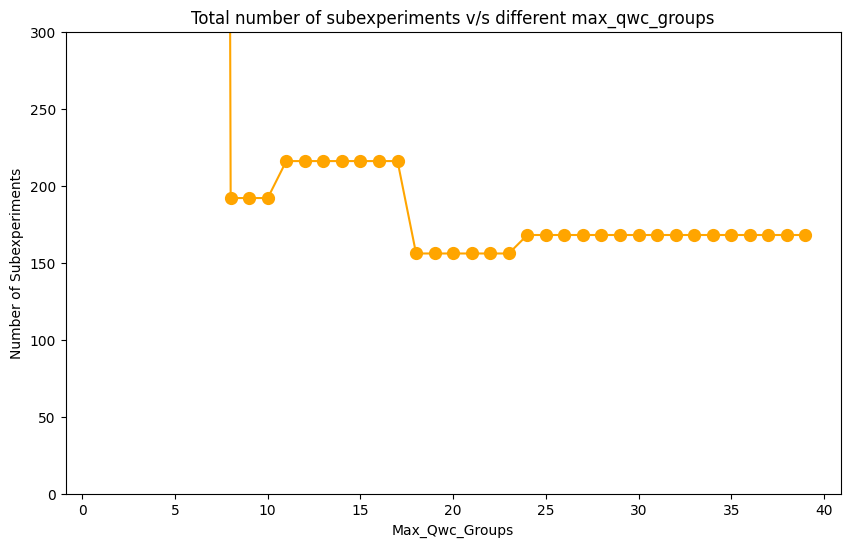

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, marker='o', markersize=8, linestyle='-', markeredgewidth=1.5, color = 'orange')
plt.title("Total number of subexperiments v/s different max_qwc_groups")
plt.xlabel("Max_Qwc_Groups")
plt.ylabel("Number of Subexperiments")


# Set the y-axis limits
plt.ylim(0, 300)  # Adjust the upper limit multiplier as needed
plt.show()
